In [1]:
import sys
sys.path.insert(1, '../')

In [2]:
import pandas as pd
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt
from tensorflow import keras

from basic_nlp_model import Model, experiment

In [3]:
df = pd.read_csv('../ensambles baseline/data/tex_physics.csv')

In [4]:
def class_decider(row):
    if row['score'] < 2.:
        return 0
    elif row['score'] > 2.:
        return 1
    else:
        if row['n_answers'] < 1.:
            return 0
        else:
            return 1

In [5]:
df.loc[:, 'y'] = df.apply(class_decider, axis=1)

In [6]:
df['y'].value_counts()

0    186511
1    184785
Name: y, dtype: int64

In [7]:
data = df[['title', 'n_lists', 'n_links', 'n_tags',
       'num_question_marks', 'wh_word_count', 'sentence_count', 'word_count',
       'example_count', 'n_linebreaks', 'title_word_count',
       'title_question_marks', 'y']]

In [8]:
train_data, val_data = train_test_split(data, test_size=0.3, stratify=data['y'], random_state=42)

In [9]:
train_data

,title,n_lists,n_links,n_tags,num_question_marks,wh_word_count,sentence_count,word_count,example_count,n_linebreaks,title_word_count,title_question_marks,y
292249,How do I install pgfpages package?,0,0,3,2,0,3,27,0,1,6,1,0
178165,AUCTeX can't find PDFLaTeX,0,0,2,1,3,6,90,0,7,5,0,1
223579,Loading microtype before or after the font,0,4,1,1,3,5,174,0,20,7,0,1
266094,Render stl files in asymptote,0,5,2,0,1,5,80,0,4,5,0,1
44330,How bright is a 150 W incandescent light bulb?,0,0,1,1,2,6,86,0,3,8,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
344381,"\usepackage{tikz} causing ""extra }"" and ""missi...",0,0,3,0,4,30,453,0,128,7,0,0
341925,Indenting all lines in a theorem environment,0,2,1,2,1,5,108,0,34,7,0,0
71506,Why is the standard deviation the error on the...,1,0,4,1,7,7,290,0,19,11,1,0
130699,When does magnetic force act as a centripetal ...,0,0,2,4,3,4,49,0,2,14,1,0


In [10]:
specs = {
    'data_path': '../ensambles baseline/data/tex_physics.csv',
    'train_data': train_data,
    'val_data': val_data,
    'max_tokens': 10000,
    'sequence_length': 20,
    'embedding_dimension': 100,
    'lstm_layers': [2, 4],
    'lstm_activation': 'tanh',
    'dense_layers': [16],
    'dense_activation': 'elu',
    'optimizer': "keras.optimizers.Adam(0.005)",
    'batch_size': 2048,
    'epochs': 10
}

In [11]:
model, results = experiment('./registry.json', specs)

Epoch 1/10
127/127 [==============================] - 13s 102ms/step - loss: 0.9984 - accuracy: 0.5424 - val_loss: 0.6528 - val_accuracy: 0.6022
Epoch 2/10
127/127 [==============================] - 12s 91ms/step - loss: 0.6429 - accuracy: 0.6102 - val_loss: 0.6530 - val_accuracy: 0.5732
Epoch 3/10
127/127 [==============================] - 12s 91ms/step - loss: 0.6225 - accuracy: 0.6320 - val_loss: 0.6595 - val_accuracy: 0.6095
Epoch 4/10
127/127 [==============================] - 12s 92ms/step - loss: 0.6098 - accuracy: 0.6480 - val_loss: 0.6596 - val_accuracy: 0.6000
Epoch 5/10
127/127 [==============================] - 12s 92ms/step - loss: 0.6026 - accuracy: 0.6591 - val_loss: 0.6753 - val_accuracy: 0.6012
Epoch 6/10
127/127 [==============================] - 12s 93ms/step - loss: 0.5849 - accuracy: 0.6745 - val_loss: 0.6933 - val_accuracy: 0.5806
Epoch 7/10
127/127 [==============================] - 12s 97ms/step - loss: 0.5746 - accuracy: 0.6831 - val_loss: 0.6981 - val_accuracy

In [12]:
results

{'data_path': '../ensambles baseline/data/tex_physics.csv',
 'max_tokens': 10000,
 'sequence_length': 20,
 'embedding_dimension': 100,
 'lstm_layers': [2, 4],
 'lstm_activation': 'tanh',
 'dense_layers': [16],
 'dense_activation': 'elu',
 'optimizer': 'keras.optimizers.Adam(0.005)',
 'batch_size': 2048,
 'epochs': 10,
 'val_accuracy': 0.593783974647522}

In [13]:
model.predict([val_data.iloc[:3, 0].to_numpy(), val_data.iloc[:3, 1:-1].to_numpy()])

array([[0.55562973],
       [0.60819477],
       [0.634112  ]], dtype=float32)

In [14]:
val_data.iloc[:3, -1]

363092    0
234864    0
227402    1
Name: y, dtype: int64

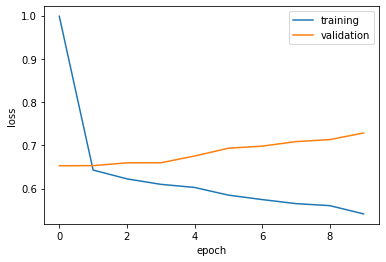

In [15]:
plt.plot(model.history['loss'])
plt.plot(model.history['val_loss'])
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['training', 'validation'])

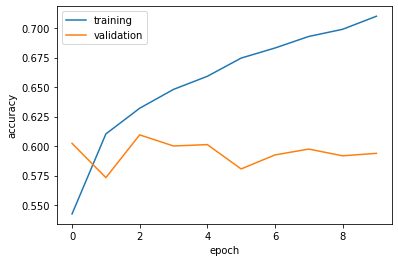

In [16]:
plt.plot(model.history['accuracy'])
plt.plot(model.history['val_accuracy'])
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.legend(['training', 'validation'])

In [26]:
tokenizer = model.tokenizer
normalizer = model.normalizer

In [27]:
specs = {
    'data_path': '../ensambles baseline/data/tex_physics.csv',
    'train_data': train_data,
    'val_data': val_data,
    'max_tokens': 10000,
    'sequence_length': 20,
    'embedding_dimension': 100,
    'lstm_layers': [2],
    'lstm_activation': 'tanh',
    'dense_layers': [8],
    'dense_activation': 'elu',
    'optimizer': "keras.optimizers.Adam(0.005)",
    'batch_size': 20000,
    'epochs': 20
}

In [28]:
model, results = experiment('./registry.json', specs, tokenizer, normalizer)

Epoch 1/20
13/13 [==============================] - 9s 724ms/step - loss: 3.0542 - accuracy: 0.4961 - val_loss: 2.0130 - val_accuracy: 0.4978
Epoch 2/20
13/13 [==============================] - 9s 690ms/step - loss: 1.2875 - accuracy: 0.4973 - val_loss: 1.0058 - val_accuracy: 0.5024
Epoch 3/20
13/13 [==============================] - 9s 687ms/step - loss: 0.8792 - accuracy: 0.5430 - val_loss: 0.7730 - val_accuracy: 0.5395
Epoch 4/20
13/13 [==============================] - 9s 716ms/step - loss: 0.7768 - accuracy: 0.5193 - val_loss: 0.7717 - val_accuracy: 0.5181
Epoch 5/20
13/13 [==============================] - 9s 708ms/step - loss: 0.7569 - accuracy: 0.5194 - val_loss: 0.7361 - val_accuracy: 0.5290
Epoch 6/20
13/13 [==============================] - 10s 734ms/step - loss: 0.7296 - accuracy: 0.5329 - val_loss: 0.7146 - val_accuracy: 0.5318
Epoch 7/20
13/13 [==============================] - 9s 728ms/step - loss: 0.7021 - accuracy: 0.5391 - val_loss: 0.6903 - val_accuracy: 0.5456
Epoch

In [29]:
results

{'data_path': '../ensambles baseline/data/tex_physics.csv',
 'max_tokens': 10000,
 'sequence_length': 20,
 'embedding_dimension': 100,
 'lstm_layers': [2],
 'lstm_activation': 'tanh',
 'dense_layers': [8],
 'dense_activation': 'elu',
 'optimizer': 'keras.optimizers.Adam(0.005)',
 'batch_size': 20000,
 'epochs': 20,
 'val_accuracy': 0.5853181481361389}

In [30]:
model.predict([val_data.iloc[:3, 0].to_numpy(), val_data.iloc[:3, 1:-1].to_numpy()])

array([[0.44956693],
       [0.6598243 ],
       [0.46760836]], dtype=float32)

In [31]:
val_data.iloc[:3, -1]

363092    0
234864    0
227402    1
Name: y, dtype: int64

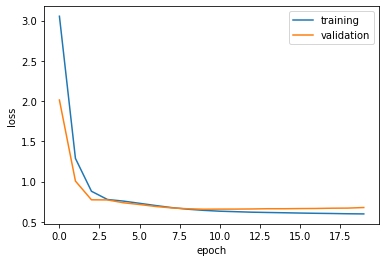

In [32]:
plt.plot(model.history['loss'])
plt.plot(model.history['val_loss'])
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['training', 'validation'])

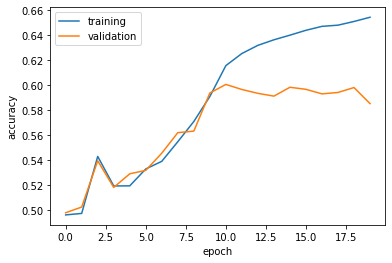

In [33]:
plt.plot(model.history['accuracy'])
plt.plot(model.history['val_accuracy'])
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.legend(['training', 'validation'])